### Home work № 2:

In [118]:
import itertools
import nltk
import numpy as np
import pandas as pd
import pymorphy2
import re
import seaborn as sns 

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
from nltk.corpus import stopwords # from nltk.tokenize import word_tokenize
from razdel import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, \
                            classification_report, precision_recall_curve, \
                            confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

Наши новости

In [119]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [120]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

##### Векторные представления новостей

In [121]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [122]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

151

In [123]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [124]:
morph = pymorphy2.MorphAnalyzer()

In [125]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text


cache = {}


def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [126]:
%%time
#Запускаем очистку текста.
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 21.5 s


In [127]:
%%time
#Запускаем лемматизацию текста.
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 4s


Обучим нашу модель

In [128]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [129]:
N_topic = 25 # число тем - гиперпараметр

In [130]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

Wall time: 30.2 s


In [131]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [132]:
x=lda.show_topics(num_topics=N_topic, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: это мочь который двигатель всё продукция страдать дональд год выяснить
topic_1: год апрель напомнить конкурс общество сектор который предполагаться норма разместить
topic_2: дело год сотрудник эксперимент это полиция мозг рф который задержать
topic_3: взрыв обращение бомба святой альянс пищевой коллекция римский калинин устанавливать
topic_4: это россия год рынок система который развитие мочь рост первый
topic_5: северный южный параметр корея сша испания таиланд германия эстония европа
topic_6: ракета журнал университет высота км испытание первый проверка флот метр
topic_7: украина украинский рак киев берег украинец это тепло акционер россия
topic_8: ребёнок человек который это год гражданин женщина закон мочь мужчина
topic_9: египет миллиард солнце остров иран памятник тур век гражданство горизонт
topic_10: планета экономика это всё мочь проверка сообщество очень который экономический
topic_11: это который год свой россия человек весь исследование мочь страна
topic_12: рост э

Функция, которая будет нам возвращать векторное представление новости

In [133]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [134]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(10)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.364405,0.000000,0.138669,0.000000,0.000000,0.000000,0.000000,...,0.0,0.277034,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,4896,0.000000,0.000000,0.000000,0.133698,0.000000,0.000000,0.000000,0.000000,0.424513,...,0.0,0.000000,0.046888,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,4897,0.294241,0.060203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.164567,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.067782,0.034373
3,4898,0.523149,0.000000,0.000000,0.000000,0.079132,0.000000,0.000000,0.000000,0.000000,...,0.0,0.026448,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,4899,0.000000,0.000000,0.526371,0.000000,0.000000,0.035068,0.000000,0.024414,0.000000,...,0.0,0.172310,0.000000,0.000000,0.000000,0.061556,0.0,0.118188,0.000000,0.000000
5,4900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.172513,0.000000,0.179617,0.054472,0.000000,0.0,0.000000,0.000000,0.000000
6,4901,0.000000,0.242464,0.055709,0.000000,0.053890,0.000000,0.000000,0.136002,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,4902,0.000000,0.000000,0.000000,0.000000,0.000000,0.465385,0.081803,0.000000,0.000000,...,0.0,0.067388,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
8,4903,0.431053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075969,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
9,4904,0.216393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.108081,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [135]:
users['articles_idf'] = \
users['articles'].apply(lambda x: " ".join([i.strip() for i in x.replace("[","").replace("]","").split(",")]), 1)

In [136]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles_idf'])

TfidfVectorizer()

In [137]:
articles_idf = pd.DataFrame({'article_id': map(int, tfidf.get_feature_names()),
              'idf': tfidf.idf_})

In [138]:
topic_matrix_idf = topic_matrix.copy()

In [139]:
topic_matrix_idf

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.364405,0.000000,0.138669,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.277034,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,4896,0.000000,0.000000,0.000000,0.133698,0.000000,0.000000,0.000000,0.000000,0.424513,...,0.000000,0.000000,0.046888,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,4897,0.294241,0.060203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.164567,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.067782,0.034373
3,4898,0.523149,0.000000,0.000000,0.000000,0.079132,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.026448,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,4899,0.000000,0.000000,0.526371,0.000000,0.000000,0.035068,0.000000,0.024414,0.000000,...,0.000000,0.172310,0.000000,0.000000,0.000000,0.061556,0.0,0.118188,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,513441,0.112865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.041980,0.000000,0.000000,0.110051,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
26996,513442,0.000000,0.000000,0.445796,0.000000,0.106400,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.053354,0.000000,0.000000,0.0,0.190153,0.000000,0.000000
26997,513443,0.057979,0.000000,0.000000,0.000000,0.000000,0.000000,0.051387,0.000000,0.000000,...,0.028749,0.000000,0.000000,0.190091,0.272812,0.000000,0.0,0.000000,0.000000,0.000000
26998,513444,0.332218,0.000000,0.000000,0.000000,0.124627,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.080966,0.239268,0.000000,0.0,0.000000,0.033878,0.000000


In [140]:
articles_idf

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [141]:
feature_names=tfidf.get_feature_names()
len(feature_names)

14781

In [142]:
articles_idf[articles_idf['article_id']==4896]['idf'].values

array([8.19556234])

In [143]:
topic_matrix_idf[topic_matrix_idf['doc_id']==4896]

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
1,4896,0.0,0.0,0.0,0.133698,0.0,0.0,0.0,0.0,0.424513,...,0.0,0.0,0.046888,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
#topic_matrix_idf = topic_matrix_idf[topic_matrix_idf['doc_id']==4896] * \
#                    articles_idf[articles_idf['article_id']==4896]['idf'].values

In [145]:
#for i in topic_matrix['doc_id']:
#    try: 
#        topic_matrix_idf.loc[topic_matrix_df['doc_id']==i,  topic_matrix_idf[:,topic_matrix_idf.columns != 'doc_id']] \
#        *= articles_idf[articles_idf['article_id'].astype(int)==i]['idf'][0]
#    except:
#        topic_matrix_idf = topic_matrix_idf[topic_matrix_idf['doc_id']==i].loc[:,topic_matrix_idf.columns != 'doc_id'] * 1

In [146]:
#topic_matrix_idf.iloc[:,1:21]

In [147]:
#topic_matrix[topic_matrix['doc_id']==6]

In [148]:
#for i in topic_matrix['doc_id']:
#    print(i)

Получили вектора наших новостей.

##### Векторные представления пользователей

In [149]:
users.head(10)

,uid,articles,articles_idf
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]",293672 293328 293001 293622 293126 1852
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]",3405 1739 2972 1158 1599 322665
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]",1845 2009 2356 1424 2939 323389
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]",5933 6186 5055 6977 5206 488389
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]",707 1144 2532 2928 3133 324592
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]",323868 323426 324267 322426 324104 1550
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]",293138 294471 295012 294736 293949 3544
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]",6928 5009 6940 7629 7644 512736
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]",322838 324699 322991 322120 324327 472331
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]",7827 6427 7394 7151 6335 487254


In [150]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [151]:
doc_dict[3405]

array([0.01561998, 0.01560063, 0.15091097, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.22149162, 0.        ,
       0.03818841, 0.12802593, 0.        , 0.        , 0.07236564,
       0.        , 0.        , 0.        , 0.06225658, 0.        ,
       0.        , 0.        , 0.27603048, 0.        , 0.        ])

In [152]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.mean(user_vector, 0)
    return user_vector1


def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.median(user_vector, 0)
    return user_vector1


def get_user_embedding_amax(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.amax(user_vector, 0)
    return user_vector1

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [153]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.026563,0.080065,0.052383,0.005865,0.045314,0.00472,0.005336,0.045096,0.112472,...,0.023369,0.047007,0.022283,0.072263,0.017123,0.00000,0.001758,0.136042,0.006924,0.003616
1,u108690,0.065246,0.033944,0.045238,0.000000,0.033285,0.00000,0.000000,0.055530,0.092876,...,0.009061,0.005469,0.000000,0.021847,0.024794,0.00000,0.006290,0.209111,0.004837,0.001772
2,u108339,0.006819,0.045277,0.065600,0.000000,0.025164,0.00000,0.006995,0.000000,0.099523,...,0.000000,0.010116,0.002730,0.069177,0.039945,0.00243,0.054313,0.211376,0.010799,0.008167


In [154]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.049309,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.116558,...,0.0,0.012754,0.0,0.042907,0.000000,0.0,0.0,0.147845,0.000000,0.0
1,u108690,0.055757,0.016941,0.019970,0.0,0.000000,0.0,0.0,0.032063,0.047524,...,0.0,0.000000,0.0,0.014201,0.006807,0.0,0.0,0.155271,0.000000,0.0
2,u108339,0.000000,0.027985,0.065295,0.0,0.024333,0.0,0.0,0.000000,0.089601,...,0.0,0.000000,0.0,0.041019,0.051715,0.0,0.0,0.241287,0.005998,0.0


In [155]:
user_embeddings_amax = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_amax(x), 1)])
user_embeddings_amax.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_amax['uid'] = users['uid'].values
user_embeddings_amax= user_embeddings_amax[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings_amax.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.117870,0.272811,0.286368,0.035189,0.271886,0.028321,0.032014,0.270576,0.255045,...,0.081403,0.132583,0.13370,0.249417,0.102736,0.00000,0.010549,0.261843,0.023751,0.021697
1,u108690,0.150969,0.092712,0.150911,0.000000,0.199707,0.000000,0.000000,0.163698,0.230240,...,0.054364,0.032816,0.00000,0.062257,0.070065,0.00000,0.019114,0.539515,0.017794,0.010633
2,u108339,0.040916,0.147131,0.132150,0.000000,0.060506,0.000000,0.041967,0.000000,0.165901,...,0.000000,0.038482,0.01638,0.198810,0.068268,0.01458,0.280171,0.394870,0.036752,0.028425


##### Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [156]:
target = pd.read_csv('users_churn.csv')
target.head()

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [157]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.026563,0.080065,0.052383,0.005865,0.045314,0.00472,0.005336,0.045096,0.112472,...,0.047007,0.022283,0.072263,0.017123,0.00000,0.001758,0.136042,0.006924,0.003616,0
1,u108690,0.065246,0.033944,0.045238,0.000000,0.033285,0.00000,0.000000,0.055530,0.092876,...,0.005469,0.000000,0.021847,0.024794,0.00000,0.006290,0.209111,0.004837,0.001772,1
2,u108339,0.006819,0.045277,0.065600,0.000000,0.025164,0.00000,0.006995,0.000000,0.099523,...,0.010116,0.002730,0.069177,0.039945,0.00243,0.054313,0.211376,0.010799,0.008167,1


In [158]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.049309,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.116558,...,0.012754,0.0,0.042907,0.000000,0.0,0.0,0.147845,0.000000,0.0,0
1,u108690,0.055757,0.016941,0.019970,0.0,0.000000,0.0,0.0,0.032063,0.047524,...,0.000000,0.0,0.014201,0.006807,0.0,0.0,0.155271,0.000000,0.0,1
2,u108339,0.000000,0.027985,0.065295,0.0,0.024333,0.0,0.0,0.000000,0.089601,...,0.000000,0.0,0.041019,0.051715,0.0,0.0,0.241287,0.005998,0.0,1


In [159]:
X_amax = pd.merge(user_embeddings_amax, target, 'left')
X_amax.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.117870,0.272811,0.286368,0.035189,0.271886,0.028321,0.032014,0.270576,0.255045,...,0.132583,0.13370,0.249417,0.102736,0.00000,0.010549,0.261843,0.023751,0.021697,0
1,u108690,0.150969,0.092712,0.150911,0.000000,0.199707,0.000000,0.000000,0.163698,0.230240,...,0.032816,0.00000,0.062257,0.070065,0.00000,0.019114,0.539515,0.017794,0.010633,1
2,u108339,0.040916,0.147131,0.132150,0.000000,0.060506,0.000000,0.041967,0.000000,0.165901,...,0.038482,0.01638,0.198810,0.068268,0.01458,0.280171,0.394870,0.036752,0.028425,1


##### Разделим данные на train/test

In [160]:
X_train_mean, X_test_mean, y_train_mean, y_test_mean = \
    train_test_split(X_mean[['topic_{}'.format(i) for i in range(N_topic)]], 
                     X_mean['churn'], random_state=0, test_size=0.3)

In [161]:
X_train_median, X_test_median, y_train_median, y_test_median = \
    train_test_split(X_median[['topic_{}'.format(i) for i in range(N_topic)]], 
                     X_median['churn'], random_state=0, test_size=0.3)

In [162]:
X_train_amax, X_test_amax, y_train_amax, y_test_amax = \
    train_test_split(X_amax[['topic_{}'.format(i) for i in range(N_topic)]], 
                     X_amax['churn'], random_state=0, test_size=0.3)

##### Обучим нашу модель

In [163]:
logreg_mean = LogisticRegression(C=1.0)
logreg_mean.fit(X_train_mean, y_train_mean)

LogisticRegression()

In [164]:
logreg_median = LogisticRegression(C=1.0)
logreg_median.fit(X_train_median, y_train_median)

LogisticRegression()

In [165]:
logreg_amax = LogisticRegression(C=1.0)
logreg_amax.fit(X_train_amax, y_train_amax)

LogisticRegression()

##### Наши прогнозы для тестовой выборки

In [166]:
preds_mean = logreg_mean.predict_proba(X_test_mean)[:, 1]
preds_mean[:10]

array([0.18560215, 0.06158357, 0.32334283, 0.14026863, 0.0724544 ,
       0.11450446, 0.10825945, 0.02405819, 0.03801123, 0.06792749])

In [167]:
preds_median = logreg_median.predict_proba(X_test_median)[:, 1]
preds_median[:10]

array([0.21021272, 0.04542897, 0.37202357, 0.15293156, 0.046893  ,
       0.05471663, 0.11859881, 0.06384277, 0.03648348, 0.04517797])

In [168]:
preds_amax = logreg_amax.predict_proba(X_test_amax)[:, 1]
preds_amax[:10]

array([0.10547536, 0.03273008, 0.56671471, 0.09415306, 0.04663792,
       0.00169218, 0.11896528, 0.00137005, 0.02133887, 0.03000166])

##### Рассчитаем Precision, Recall, F_score

In [169]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test_mean.values, preds_mean)

In [170]:
b=1
fscore_mean = ((1+b**2) * precision_mean * recall_mean) / (b**2*precision_mean + recall_mean)
# locate the index of the largest f score
ix = np.argmax(fscore_mean)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_mean[ix], 
                                                                                            fscore_mean[ix],
                                                                                            precision_mean[ix],
                                                                                            recall_mean[ix]))
t_mean = thresholds_mean[ix]

Best Threshold_mean=0.255905, F-Score_mean=0.678, Precision_mean=0.667, Recall_mean=0.689


In [171]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test_median.values, preds_median)

In [172]:
b=1
fscore_median = ((1+b**2) * precision_median * recall_median) / (b**2*precision_median + recall_median)
# locate the index of the largest f score
ix = np.argmax(fscore_median)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_median[ix], 
                                                                                            fscore_median[ix],
                                                                                            precision_median[ix],
                                                                                            recall_median[ix]))
t_median = thresholds_median[ix]

Best Threshold_mean=0.270687, F-Score_mean=0.757, Precision_mean=0.730, Recall_mean=0.785


In [173]:
precision_amax, recall_amax, thresholds_amax = precision_recall_curve(y_test_amax.values, preds_amax)

In [174]:
b=1
fscore_amax = ((1+b**2) * precision_amax * recall_amax) / (b**2*precision_amax + recall_amax)
# locate the index of the largest f score
ix = np.argmax(fscore_amax)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_amax[ix], 
                                                                                            fscore_amax[ix],
                                                                                            precision_amax[ix],
                                                                                            recall_amax[ix]))
t_amax = thresholds_amax[ix]

Best Threshold_mean=0.310604, F-Score_mean=0.776, Precision_mean=0.745, Recall_mean=0.809


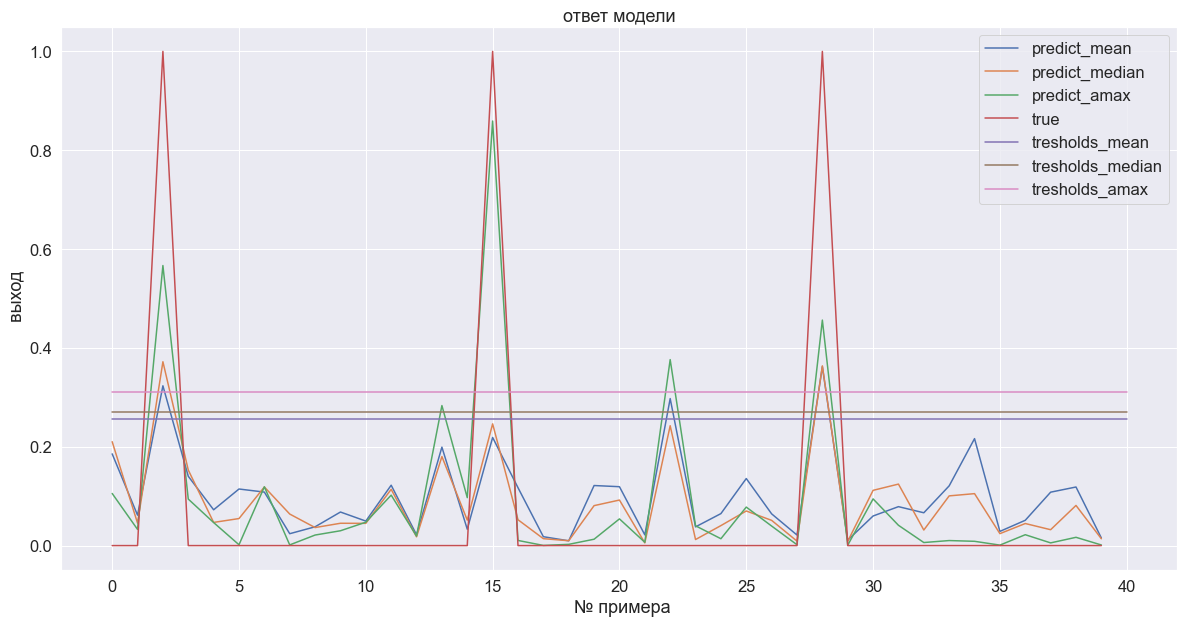

In [175]:
%matplotlib inline

plt.figure(figsize = (20, 10))
plt.plot( preds_mean[:40], label = 'predict_mean')
plt.plot( preds_median[:40], label = 'predict_median')
plt.plot( preds_amax[:40], label = 'predict_amax')
plt.plot(y_test_mean.values[:40], label = 'true')
plt.plot([0,40],[t_mean,t_mean],label = 'tresholds_mean')
plt.plot([0,40],[t_median,t_median],label = 'tresholds_median')
plt.plot([0,40],[t_amax,t_amax],label = 'tresholds_amax')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

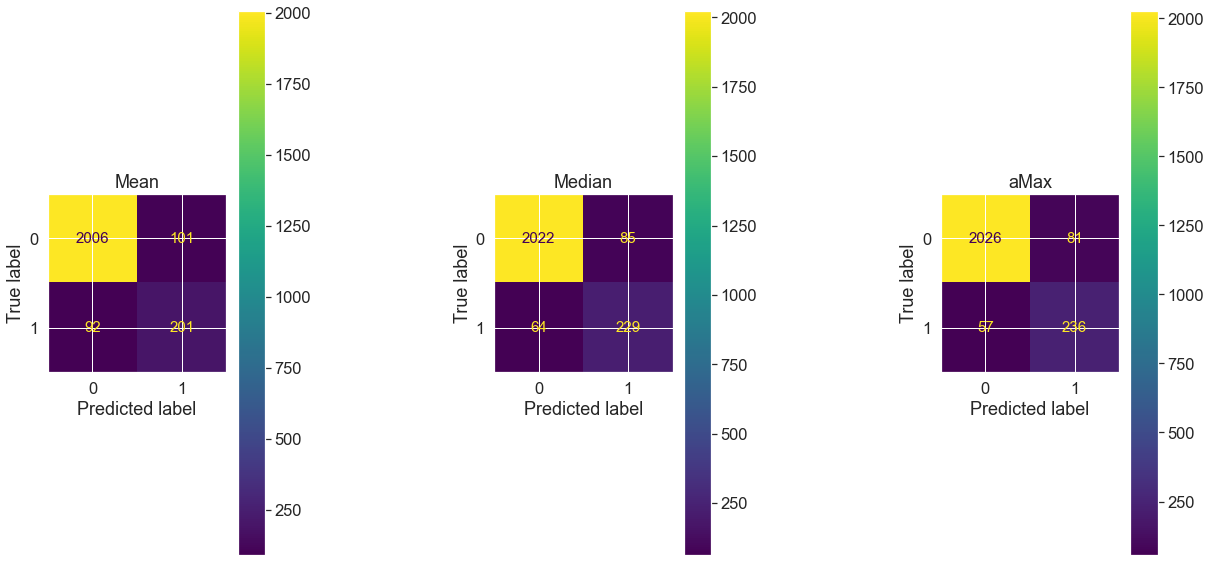

In [176]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
cnf_matrix = []
cnf_matrix.append(confusion_matrix(y_test_mean, preds_mean>t_mean))
cnf_matrix.append(confusion_matrix(y_test_median, preds_median>t_median))
cnf_matrix.append(confusion_matrix(y_test_amax, preds_amax>t_amax))
key = ['Mean', 'Median', 'aMax']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
font = {'size' : 15}
plt.rc('font', **font)
for i in range(0,3):
    disp = ConfusionMatrixDisplay(cnf_matrix[i])
    disp.plot(ax=axes[i])
    disp.ax_.set_title(key[i])
plt.subplots_adjust(wspace=1, hspace=0.1)
plt.savefig("confusion_matrix.png")
plt.show()


In [177]:
roc_auc_score_mean = roc_auc_score(y_true=y_test_mean, y_score=preds_mean)
roc_auc_score_median = roc_auc_score(y_true=y_test_median, y_score=preds_median)
roc_auc_score_amax = roc_auc_score(y_true=y_test_amax, y_score=preds_amax)

print(f'Roc auc score for Mean embedding: {roc_auc_score_mean}')
print(f'Roc auc score for Median embedding: {roc_auc_score_median}')
print(f'Roc auc score for aMax embedding: {roc_auc_score_amax}')

Roc auc score for Mean embedding: 0.9495878357692787
Roc auc score for Median embedding: 0.9700202963954055
Roc auc score for aMax embedding: 0.9702972863087612


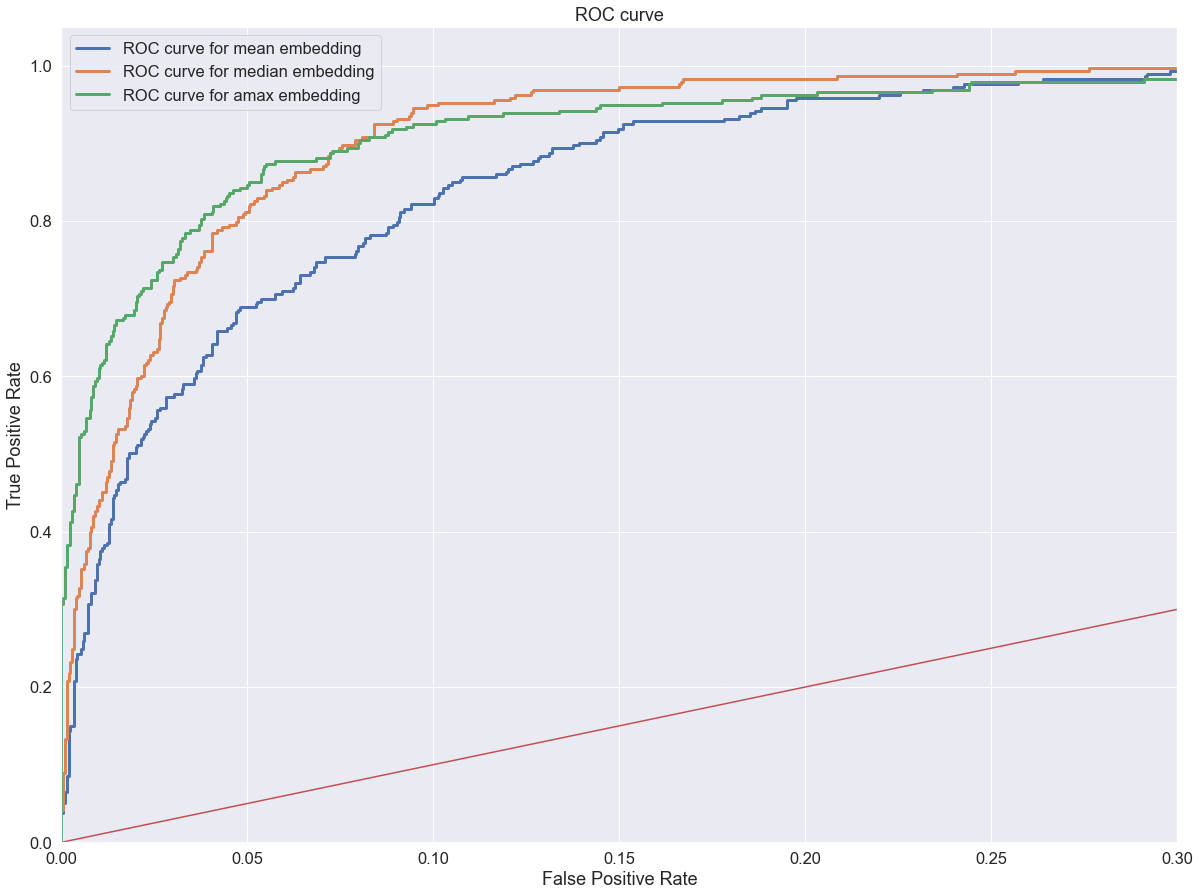

In [178]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(20, 15))
fpr_mean, tpr_mean, thresholds_mean = roc_curve(y_test_mean, preds_mean, pos_label=1)
fpr_median, tpr_median, thresholds_median = roc_curve(y_test_median, preds_median, pos_label=1)
fpr_amax, tpr_amax, thresholds_amax = roc_curve(y_test_amax, preds_amax, pos_label=1)
lw = 3
plt.plot(fpr_mean, tpr_mean, lw=lw, label='ROC curve for mean embedding')
plt.plot(fpr_median, tpr_median, lw=lw, label='ROC curve for median embedding')
plt.plot(fpr_amax, tpr_amax, lw=lw, label='ROC curve for amax embedding')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, .3])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.png")
plt.show()

### Лучший результат с aMax embedding